In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Flatten, Conv1D, GRU, MaxPool1D, Dropout
from keras import metrics
from livelossplot import PlotLossesKeras

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

## Plot library

In [4]:
def plot_windows(X, Y, Y_pred):
    plt.figure(figsize=(8, 4))
    plt.plot(X[0,:], "o-")
    if Y is not None:
        plt.plot(np.arange(look_back, look_back + look_forward), Y[0, :], "go", label="Actual")
    if Y_pred is not None:
        plt.plot(np.arange(look_back, look_back + look_forward), Y_pred[0, :], "rx-", label="Forecast", markersize=10)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.axvline(look_back, color='gray',linestyle='--',linewidth=2)
    plt.show()

In [5]:
def plot_pred(ymin,ymax):
    plt.figure(figsize=(5, 4))
    plt.scatter(y_test.flatten(), y_pred.flatten())
    plt.xlabel('Acutal')
    plt.ylabel('Predictions [ToVol]')
    plt.plot([ymin,ymax], [ymin,ymax],color='gray',linestyle='--',linewidth=2)
    plt.show()

In [6]:
def plot_learning_curves(loss, val_loss):
    plt.figure(figsize=(8, 4))
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [7]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back, look_forward):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        if len(dataset[i + look_back:i+look_back+look_forward]) == look_forward:
            dataX.append(a)
            dataY.append(dataset[i + look_back:i+look_back+look_forward])
    return np.array(dataX), np.array(dataY)

## Generate the Dataset

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/hongsukyi/Lectures/main/data/vds16.csv')
df.head()

,Date,ToVol,SmVol,MeVol,LaVol,Speed,OccRate
0,2017-04-02 0:00,43,34,9,0,50.3,1.90
1,2017-04-02 0:05,45,32,13,0,58.9,1.84
2,2017-04-02 0:10,46,34,12,0,50.6,1.87
3,2017-04-02 0:15,45,36,9,0,50.9,1.72
4,2017-04-02 0:20,27,13,13,1,62.2,1.12


<Axes: >

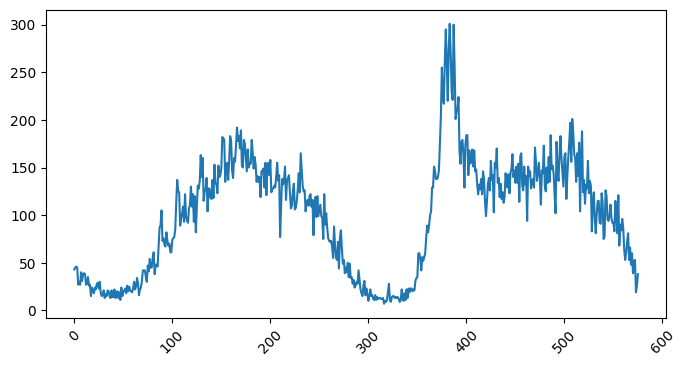

In [9]:
df['ToVol'][:576].plot(rot=45,figsize=(8,4))

In [10]:
#features = ['ToVol','LaVol','MeVol','SmVol','OccRate']
df = df[['ToVol']]

In [11]:
df

,ToVol
0,43
1,45
2,46
3,45
4,27
...,...
8059,45
8060,47
8061,32
8062,31


In [12]:
#scaler = StandardScaler()
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

In [13]:
print(df_scaled)
#print(scaled_y)

[[0.11144578]
 [0.11746988]
 [0.12048193]
 ...
 [0.07831325]
 [0.0753012 ]
 [0.09939759]]


In [14]:
look_back = 12*5
look_forward = 1

In [15]:
X, y = create_dataset(df_scaled,look_back,look_forward)

In [16]:
X.shape, y.shape

((8003, 60, 1), (8003, 1, 1))

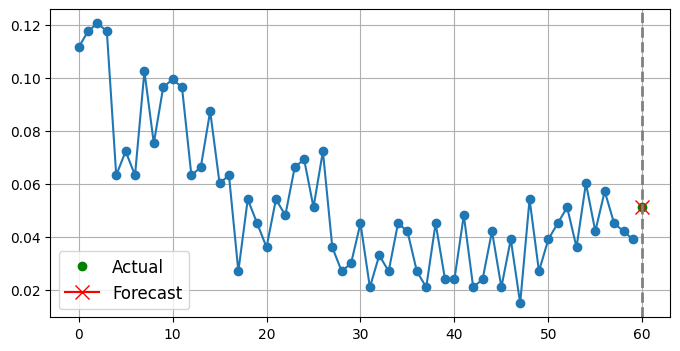

In [17]:
plot_windows(X,y,y)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
print('X_train:', X_train.shape)
print('X_test :', X_test.shape)
print('y_train:', y_train.shape)
print('y_test :', y_test.shape)

X_train: (6402, 60, 1)
X_test : (1601, 60, 1)
y_train: (6402, 1, 1)
y_test : (1601, 1, 1)


## 1) many-to-one with Baselines (MSE)

Naive predictions (just predict the last observed value):

In [19]:
y_pred = X_test[:, -1]

In [20]:
y_pred.shape

(1601, 1)

In [21]:
y_pred = y_pred[:,np.newaxis]
X_test.shape, y_test.shape, y_pred.shape

((1601, 60, 1), (1601, 1, 1), (1601, 1, 1))

In [22]:
def model_mse():
    model = np.mean(tf.keras.losses.mean_squared_error(y_test, y_pred))
    return model

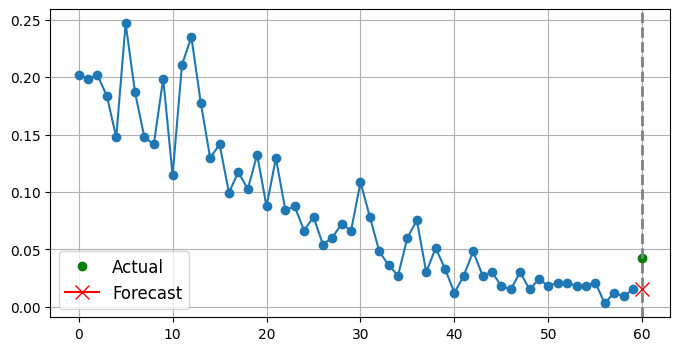

In [23]:
plot_windows(X_test[:, :], y_test[:,], y_pred[:,])

In [24]:
model = model_mse()
a1 = model
print('m1_mse: ', a1)

m1_mse:  0.00524237668448075


1.0 0.0


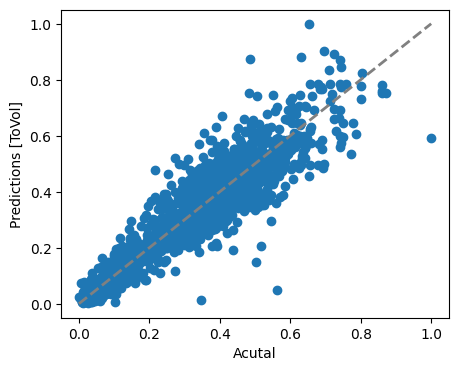

In [25]:
y_max =y_test.flatten()[:,].max()
y_min =y_test.flatten()[:,].min()
print(y_max,y_min)
plot_pred(y_min,y_max)

## 2) many-to-one with DNN

In [26]:
def model_dnn():
    model = Sequential([ Flatten(input_shape=[look_back,1]),
                        Dense(100, activation='relu'),
                        Dense(look_forward) ])
    optimizers = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss="mse", optimizer=optimizers,metrics =['mae'])
    model.summary()
    return model

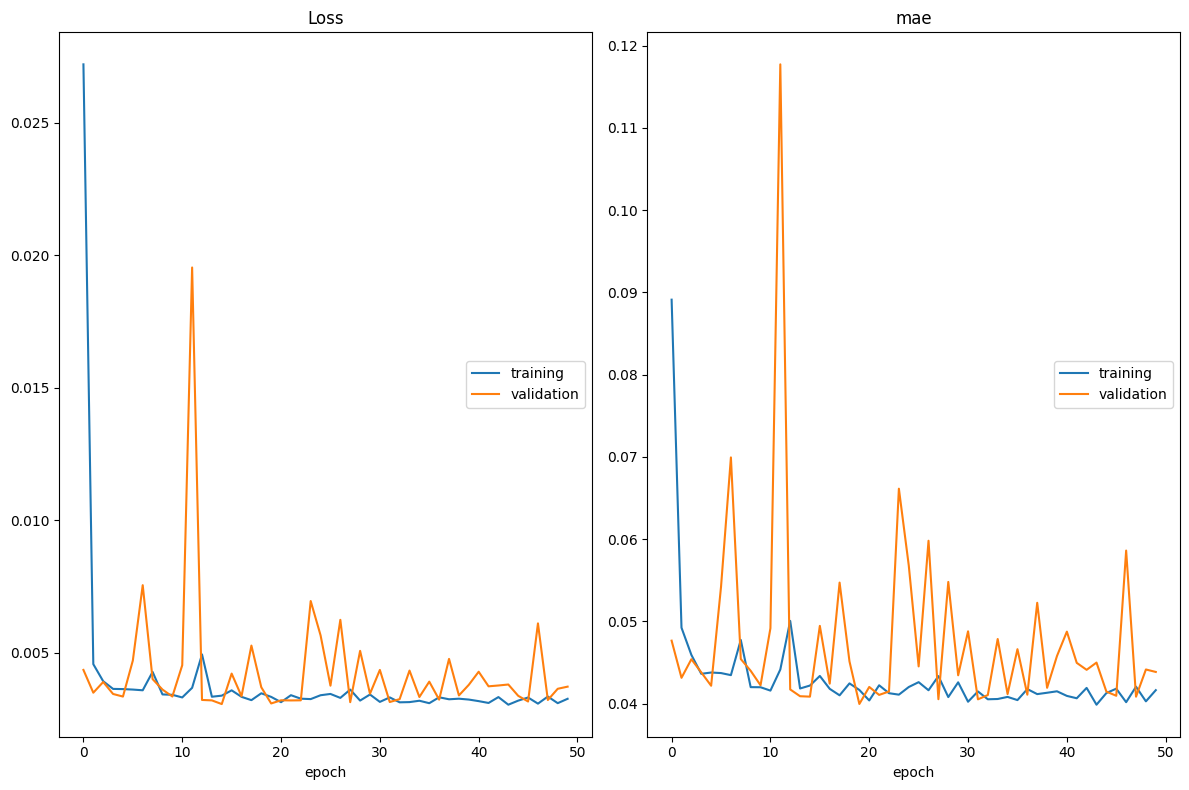

Loss
	training         	 (min:    0.003, max:    0.027, cur:    0.003)
	validation       	 (min:    0.003, max:    0.020, cur:    0.004)
mae
	training         	 (min:    0.040, max:    0.089, cur:    0.042)
	validation       	 (min:    0.040, max:    0.118, cur:    0.044)
161/161 [==============================] - 1s 3ms/step - loss: 0.0033 - mae: 0.0416 - val_loss: 0.0037 - val_mae: 0.0438


In [27]:
model = model_dnn()
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2,  callbacks=[PlotLossesKeras()])

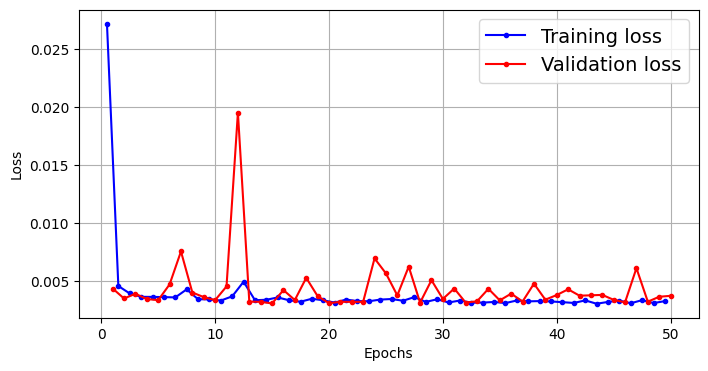

In [28]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

51/51 [==============================] - 0s 719us/step


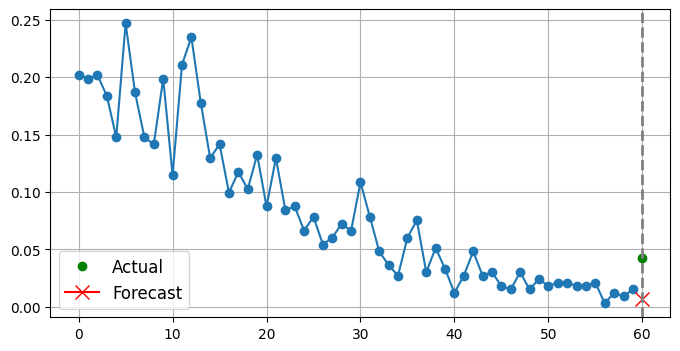

In [29]:
y_pred = model.predict(X_test)
plot_windows(X_test[:, :], y_test[:, :], y_pred[:, :])
plt.show()

In [30]:
a2, _ = model.evaluate(X_test, y_test)
print('m2_dense: ', a2)

51/51 [==============================] - 0s 875us/step - loss: 0.0040 - mae: 0.0445
m2_dense:  0.004001076798886061


1.0 0.0


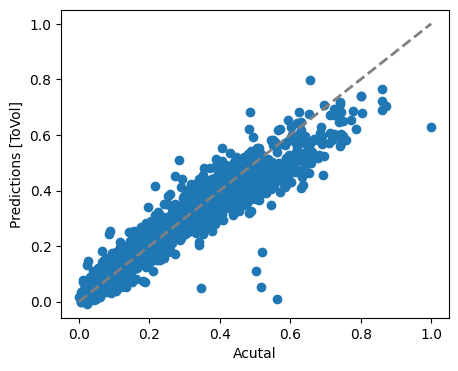

In [31]:
y_max =y_test.flatten()[:,].max()
y_min =y_test.flatten()[:,].min()
print(y_max,y_min)
plot_pred(y_min,y_max)

## 3) many-to-one with SimpleRNN

In [32]:
def model_simpleRNN():
    model = Sequential([
        SimpleRNN(10, return_sequences=True, input_shape=[look_back, 1]),
        Dropout(0.2),
        SimpleRNN(10),
        Dropout(0.2),
        Dense(look_forward)
    ])
    optimizers = tf.keras.optimizers.Adam(learning_rate=0.005)
    model.compile(loss="mse", optimizer=optimizers,metrics =['mae'])
    model.summary()
    return model

In [33]:
model = model_simpleRNN()
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2)
#history = model.fit(X_train, y_train, epochs=50, validation_split=0.2,  callbacks=[PlotLossesKeras()])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 60, 10)            120       
                                                                 
 dropout (Dropout)           (None, 60, 10)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10)                210       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
161/161 [==============================] - 3s

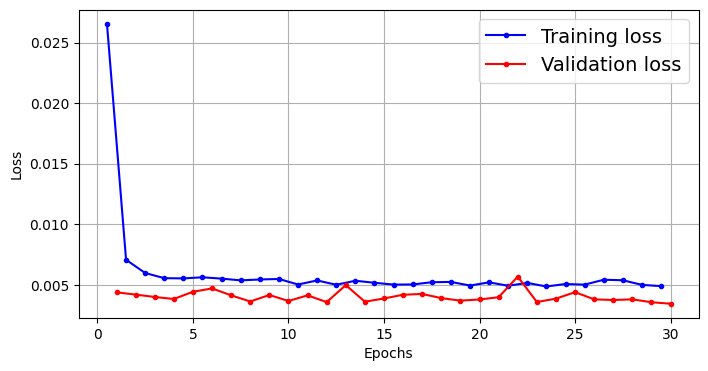

In [34]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

51/51 [==============================] - 0s 4ms/step


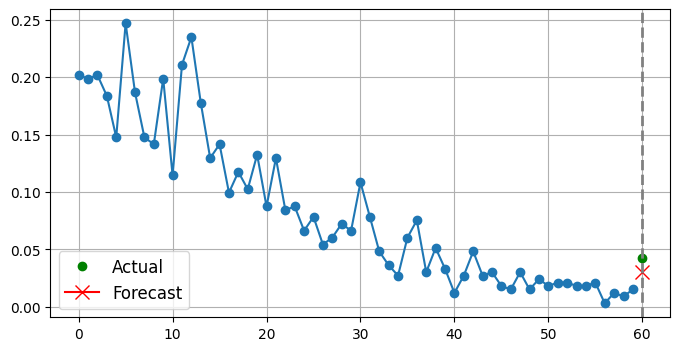

In [35]:
y_pred = model.predict(X_test)
plot_windows(X_test[:, :], y_test[:, :], y_pred[:, :])

In [36]:
a3, _ = model.evaluate(X_test, y_test)
print('m3_simpleRnn: ', a3)

51/51 [==============================] - 0s 4ms/step - loss: 0.0037 - mae: 0.0431
m3_simpleRnn:  0.0036825519055128098


1.0 0.0


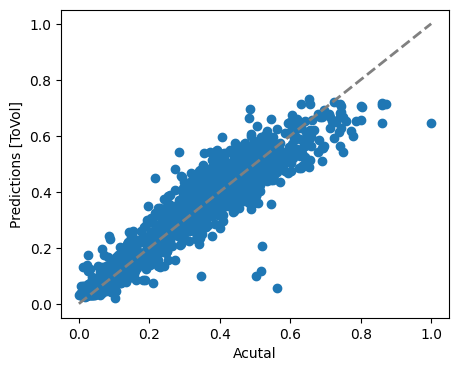

In [37]:
y_max =y_test.flatten()[:,].max()
y_min =y_test.flatten()[:,].min()
print(y_max,y_min)
plot_pred(y_min,y_max)

## 4) many-to-one with LSTM

In [38]:
def model_lstm():
    model = Sequential([
        LSTM(10, return_sequences=True, input_shape=[look_back, 1]),
        Dropout(0.2),
        LSTM(10, return_sequences=False),
        Dropout(0.2),
        Dense(look_forward)
    ])
    optimizers = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss="mse", optimizer=optimizers,metrics =['mae'])
    model.summary()
    return model

In [39]:
model = model_lstm()
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 10)            480       
                                                                 
 dropout_2 (Dropout)         (None, 60, 10)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
161/161 [==============================] 

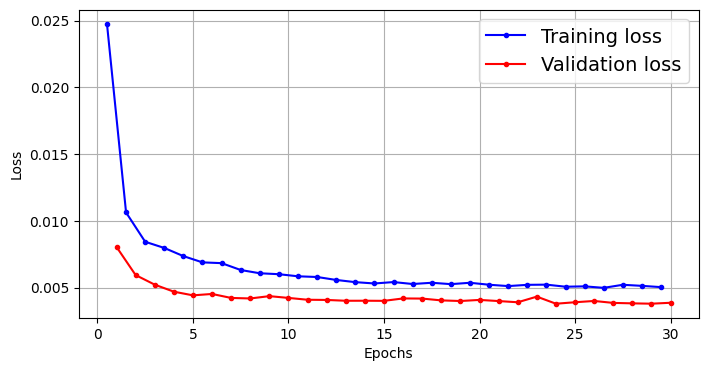

In [40]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

51/51 [==============================] - 1s 5ms/step


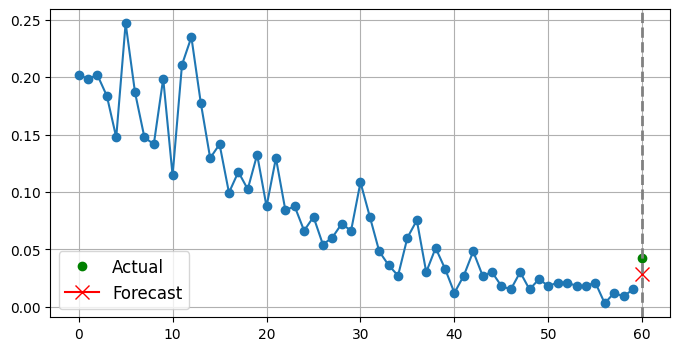

In [41]:
y_pred = model.predict(X_test)
plot_windows(X_test[:, :], y_test[:, :], y_pred[:, :])

In [42]:
a4, _ = model.evaluate(X_test, y_test)
print('m1_LSTM: ', a4)

51/51 [==============================] - 0s 5ms/step - loss: 0.0041 - mae: 0.0454
m1_LSTM:  0.004120851866900921


1.0 0.0


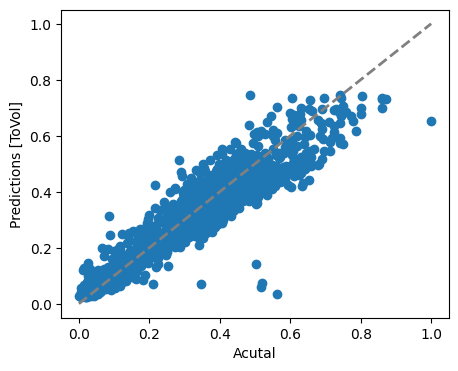

In [43]:
y_max =y_test.flatten()[:,].max()
y_min =y_test.flatten()[:,].min()
print(y_max,y_min)
plot_pred(y_min,y_max)

## many-to-one with GRU

In [44]:
def model_gru():
    model = Sequential([
        GRU(10, return_sequences=True, input_shape=[look_back, 1]),
        GRU(10, return_sequences=True),
        GRU(look_forward, return_sequences=False),
        Dense(look_forward)
    ])
    optimizers = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss="mse", optimizer=optimizers,metrics =['mae'])
    model.summary()
    return model

In [45]:
model = model_gru()
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 10)            390       
                                                                 
 gru_1 (GRU)                 (None, 60, 10)            660       
                                                                 
 gru_2 (GRU)                 (None, 1)                 39        
                                                                 
 dense_4 (Dense)             (None, 1)                 2         
                                                                 
Total params: 1,091
Trainable params: 1,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
161/161 [==============================] - 12s 49ms/step - loss: 0.0280 - mae: 0.1165 - val_loss: 0.0053 - val_mae: 0.0522
Epoch 2/30
161/161 [==============================

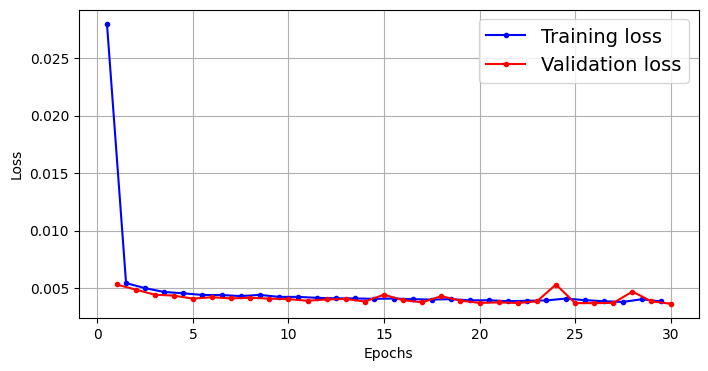

In [46]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

51/51 [==============================] - 1s 8ms/step


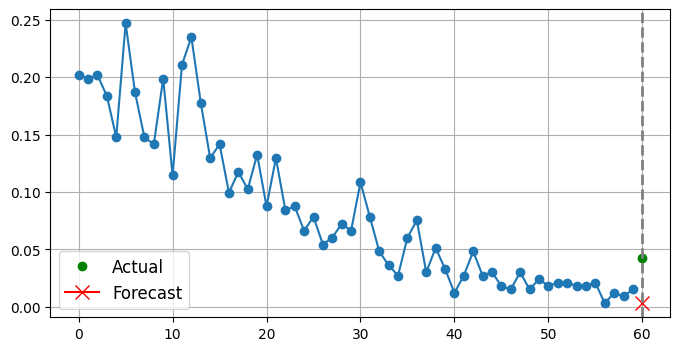

In [47]:
y_pred = model.predict(X_test)
plot_windows(X_test[:, :], y_test[:, :], y_pred[:, :])

In [48]:
a5, _ = model.evaluate(X_test, y_test)
print('m1_GRU: ', a5)

51/51 [==============================] - 0s 7ms/step - loss: 0.0039 - mae: 0.0440
m1_GRU:  0.0038955758791416883


1.0 0.0


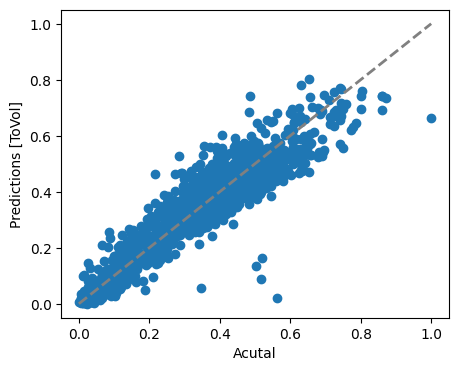

In [49]:
y_max =y_test.flatten()[:,].max()
y_min =y_test.flatten()[:,].min()
print(y_max,y_min)
plot_pred(y_min,y_max)

## 6) many-to-one with CNN1D

In [50]:
def model_conv1d():
    model = Sequential([
        Conv1D(filters=10, kernel_size=3, strides=1, padding='valid', activation='relu', 
               input_shape = (look_back,1)), 
        MaxPool1D(2, padding = 'valid'), 
        Flatten(),
        Dense(look_forward) 
    ])
    optimizers = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss="mse", optimizer=optimizers,metrics =['mae'])
    return model

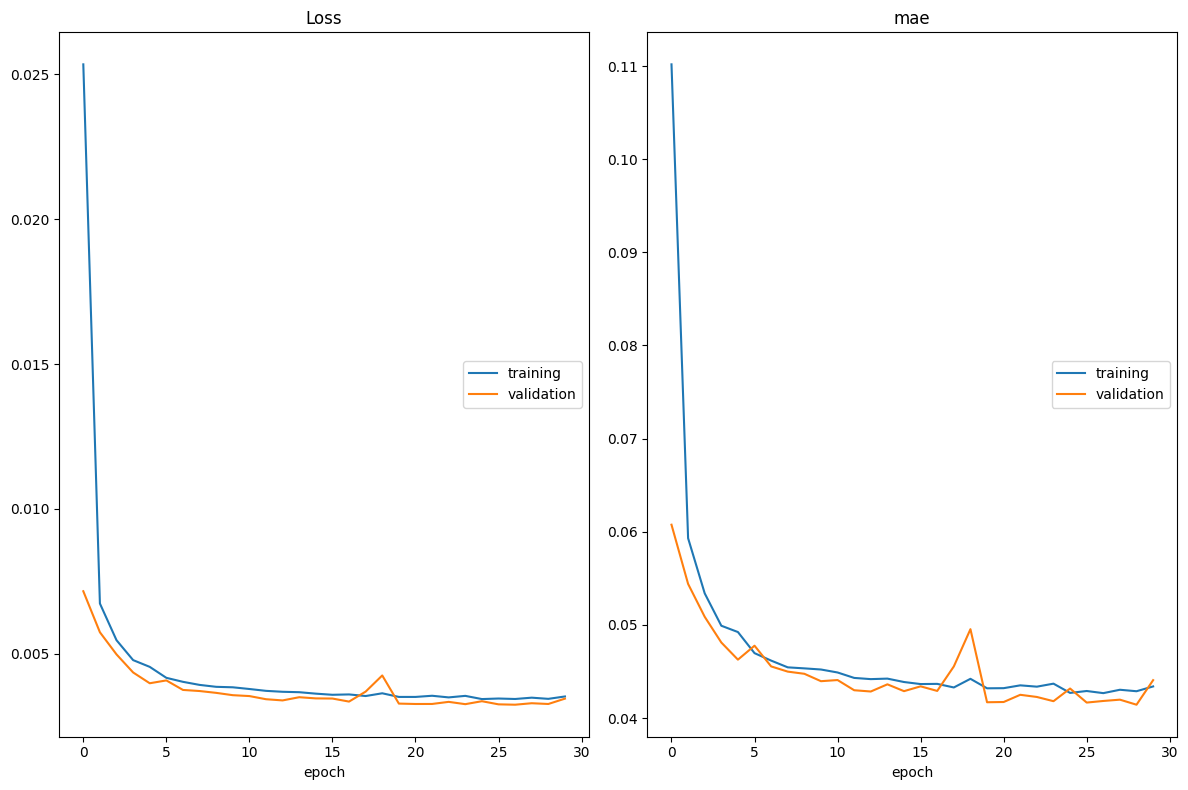

Loss
	training         	 (min:    0.003, max:    0.025, cur:    0.004)
	validation       	 (min:    0.003, max:    0.007, cur:    0.003)
mae
	training         	 (min:    0.043, max:    0.110, cur:    0.043)
	validation       	 (min:    0.041, max:    0.061, cur:    0.044)
161/161 [==============================] - 1s 4ms/step - loss: 0.0035 - mae: 0.0434 - val_loss: 0.0035 - val_mae: 0.0441


In [51]:
model = model_conv1d()
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2,  callbacks=[PlotLossesKeras()])

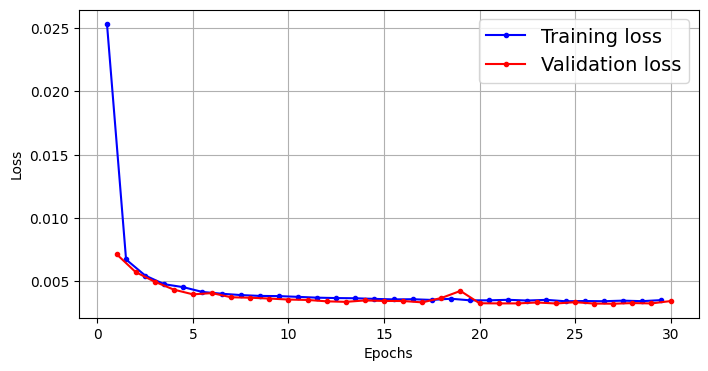

In [52]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

51/51 [==============================] - 0s 950us/step


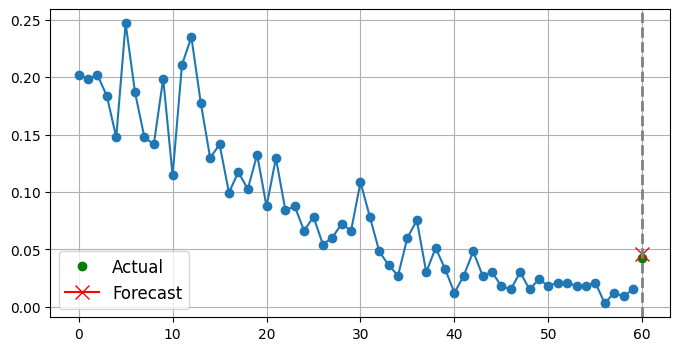

In [53]:
y_pred = model.predict(X_test)
plot_windows(X_test[:, :], y_test[:, :], y_pred[:, :])

51/51 [==============================] - 0s 1ms/step - loss: 0.0041 - mae: 0.0459
m1_Conv1D:  0.00408105319365859
1.0 0.0


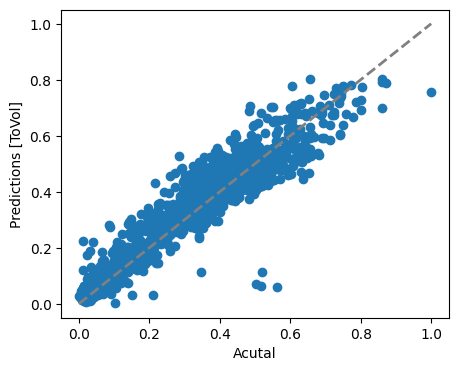

In [54]:
a6, _ = model.evaluate(X_test, y_test)
print('m1_Conv1D: ', a6)

y_max =y_test.flatten()[:,].max()
y_min =y_test.flatten()[:,].min()
print(y_max,y_min)
plot_pred(y_min,y_max)

## 7) many-to-one with LSTM-CNN1D

In [55]:
def model_cnnlstm():    
    model = Sequential([
        Conv1D(filters=10, kernel_size=3, strides=1, padding='valid', 
               activation='relu', input_shape = (look_back,1)), 
        MaxPool1D(2, padding = 'valid'), 
        LSTM(10, return_sequences=True),
        Flatten(),
        Dense(look_forward, activation='relu') 
    ])  
    optimizers = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss="mse", optimizer=optimizers,metrics =['mae'])
    return model

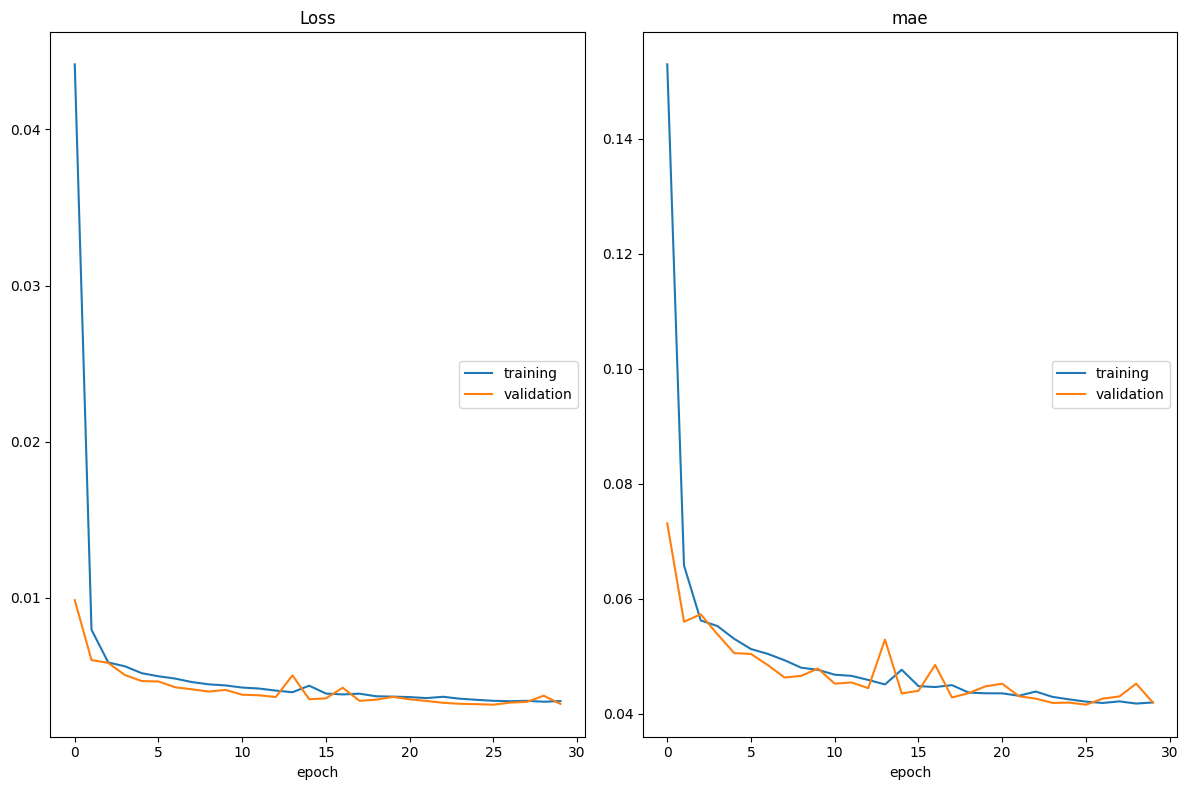

Loss
	training         	 (min:    0.003, max:    0.044, cur:    0.003)
	validation       	 (min:    0.003, max:    0.010, cur:    0.003)
mae
	training         	 (min:    0.042, max:    0.153, cur:    0.042)
	validation       	 (min:    0.042, max:    0.073, cur:    0.042)
161/161 [==============================] - 2s 10ms/step - loss: 0.0034 - mae: 0.0420 - val_loss: 0.0032 - val_mae: 0.0420


In [56]:
model = model_cnnlstm()
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2,  callbacks=[PlotLossesKeras()])

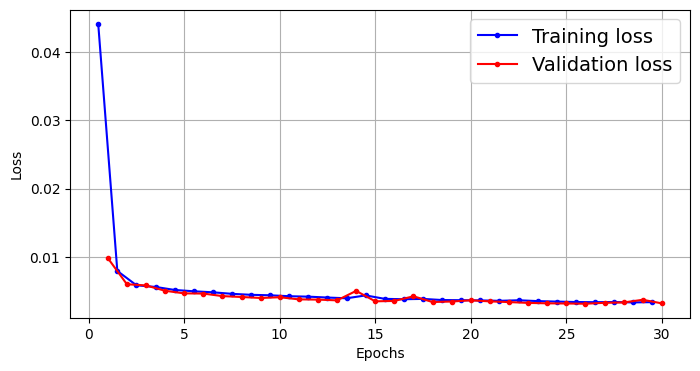

In [57]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

51/51 [==============================] - 0s 3ms/step


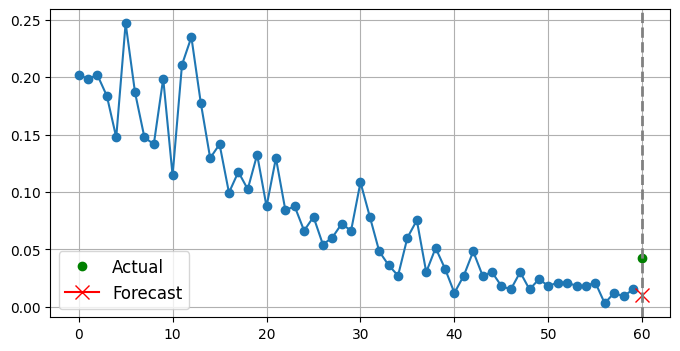

In [58]:
y_pred = model.predict(X_test)
plot_windows(X_test[:, :], y_test[:, :], y_pred[:, :])

51/51 [==============================] - 0s 3ms/step - loss: 0.0038 - mae: 0.0431
m1_Hybrid:  0.0037616854533553123
1.0 0.0


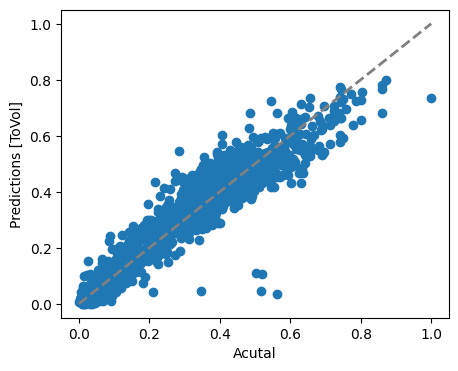

In [59]:
a7, _ = model.evaluate(X_test, y_test)
print('m1_Hybrid: ', a7)

y_max =y_test.flatten()[:,].max()
y_min =y_test.flatten()[:,].min()
print(y_max,y_min)
plot_pred(y_min,y_max)

## Summary I : Many to One Applications

In [60]:
df = pd.DataFrame({
    'models': ['mse', 'Dense', 'SimpleRNN','LSTM','GRU', 'Conv1D','CNN-LSTM' ],
    'loss':[a1, a2, a3, a4, a5, a6, a7]})
df=df.sort_values(by='loss', ascending=True)

In [61]:
df

,models,loss
2,SimpleRNN,0.003683
6,CNN-LSTM,0.003762
4,GRU,0.003896
1,Dense,0.004001
5,Conv1D,0.004081
3,LSTM,0.004121
0,mse,0.005242


<Axes: xlabel='models'>

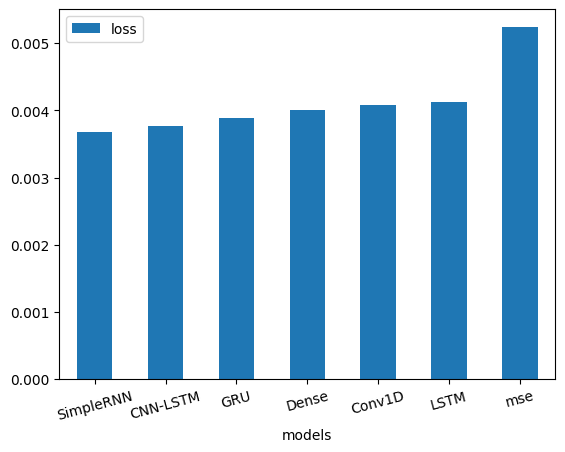

In [62]:
df.plot.bar(x='models',y='loss',rot=15)

# PART II:  Forecasting Several Steps Ahead

In [63]:
look_back = 12*5
look_forward = 12*6

In [64]:
X, y = create_dataset(df_scaled,look_back,look_forward)

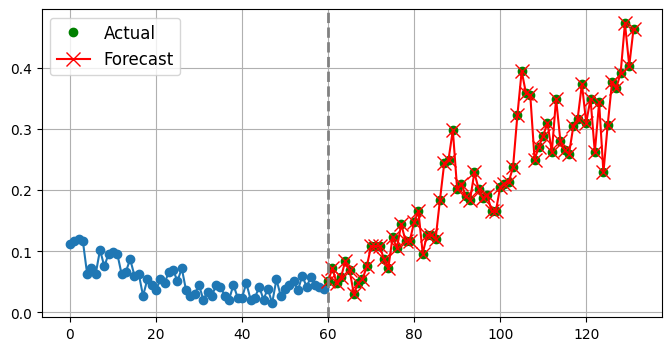

In [65]:
plot_windows(X,y,y)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                test_size=0.20, shuffle=False)

print('X_train:', X_train.shape)
print('X_test :', X_test.shape)
print('y_train:', y_train.shape)
print('y_test :', y_test.shape)

X_train: (6346, 60, 1)
X_test : (1587, 60, 1)
y_train: (6346, 72, 1)
y_test : (1587, 72, 1)


## (1) m2: many-to-many with DNN

In [67]:
model = model_dnn()
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, verbose=1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 60)                0         
                                                                 
 dense_7 (Dense)             (None, 100)               6100      
                                                                 
 dense_8 (Dense)             (None, 72)                7272      
                                                                 
Total params: 13,372
Trainable params: 13,372
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
159/159 [==============================] - 1s 2ms/step - loss: 0.0236 - mae: 0.1182 - val_loss: 0.0146 - val_mae: 0.0936
Epoch 2/30
159/159 [==============================] - 0s 1ms/step - loss: 0.0140 - mae: 0.0909 - val_loss: 0.0112 - val_mae: 0.0801
Epoch 3/30
159/159 [==============================

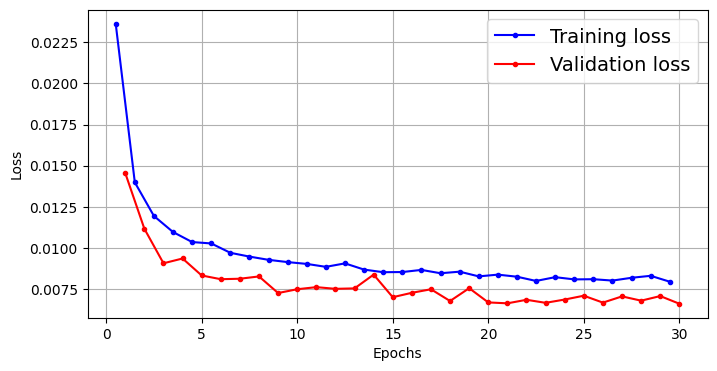

In [68]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

In [69]:
b1, _ = model.evaluate(X_test, y_test)
print('m2_SimpleRNN): ', b1)

50/50 [==============================] - 0s 889us/step - loss: 0.0065 - mae: 0.0605
m2_SimpleRNN):  0.0064973244443535805


50/50 [==============================] - 0s 744us/step


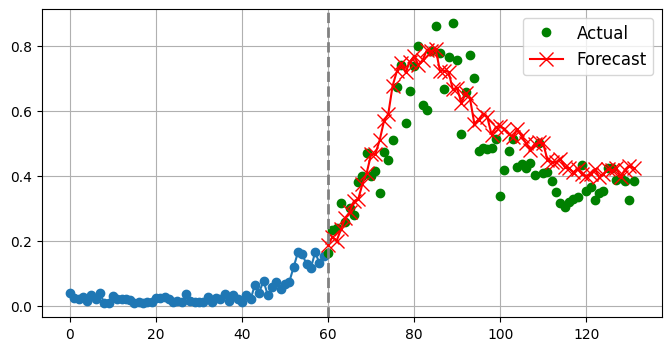

In [70]:
y_pred = model.predict(X_test)
plot_windows(X_test[:, :], y_test[:, :], y_pred[:, :])

0.9277108433734941 0.0030120481927710836


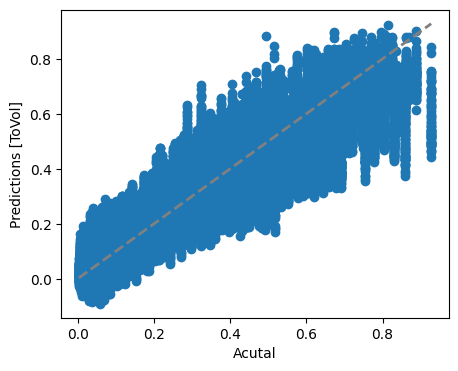

In [71]:
y_max =y_test.flatten()[:,].max()
y_min =y_test.flatten()[:,].min()
print(y_max,y_min)
plot_pred(y_min,y_max)

## model (b2) : Deep SimpleRNN
- Now let's create an RNN that predicts all 10 next values at once:

In [72]:
model = model_simpleRNN()
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, verbose=1)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 60, 10)            120       
                                                                 
 dropout_4 (Dropout)         (None, 60, 10)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 10)                210       
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                                 
 dense_9 (Dense)             (None, 72)                792       
                                                                 
Total params: 1,122
Trainable params: 1,122
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
159/159 [==============================] 

50/50 [==============================] - 0s 4ms/step


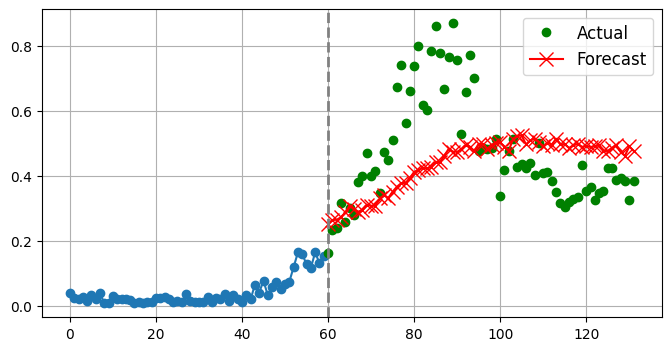

In [73]:
y_pred = model.predict(X_test)
plot_windows(X_test[:, :], y_test[:, :], y_pred[:, :])

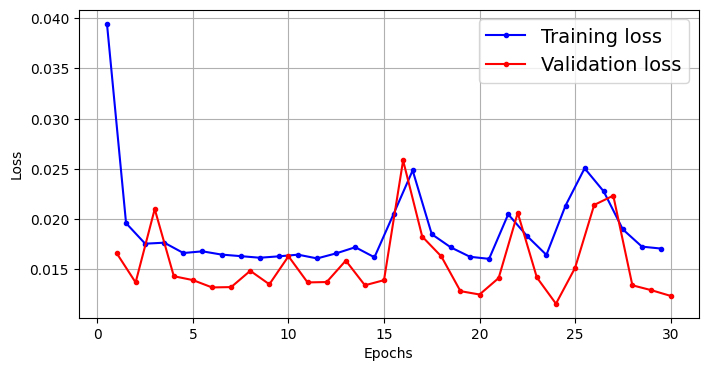

In [74]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

In [75]:
b2, _ = model.evaluate(X_test, y_test)
print('m2_SimpleRnn): ', b2)

50/50 [==============================] - 0s 4ms/step - loss: 0.0122 - mae: 0.0801
m2_SimpleRnn):  0.012189636938273907


0.9277108433734941 0.0030120481927710836


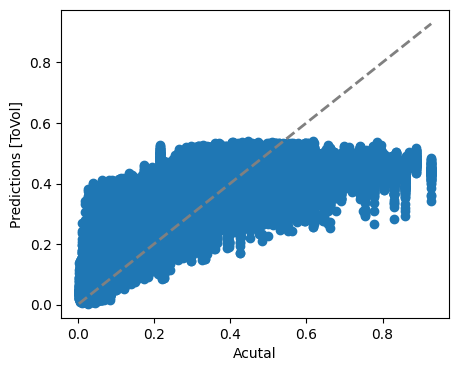

In [76]:
y_max =y_test.flatten()[:,].max()
y_min =y_test.flatten()[:,].min()
print(y_max,y_min)
plot_pred(y_min,y_max)

## b3) many to many with LSTM

In [77]:
model = model_lstm()
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, verbose=1)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 10)            480       
                                                                 
 dropout_6 (Dropout)         (None, 60, 10)            0         
                                                                 
 lstm_4 (LSTM)               (None, 10)                840       
                                                                 
 dropout_7 (Dropout)         (None, 10)                0         
                                                                 
 dense_10 (Dense)            (None, 72)                792       
                                                                 
Total params: 2,112
Trainable params: 2,112
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
159/159 [==============================] 

In [78]:
b3, _ = model.evaluate(X_test, y_test)
print('horizon model b3: ', b3)

50/50 [==============================] - 0s 6ms/step - loss: 0.0074 - mae: 0.0621
horizon model b3:  0.007379526272416115


50/50 [==============================] - 1s 7ms/step


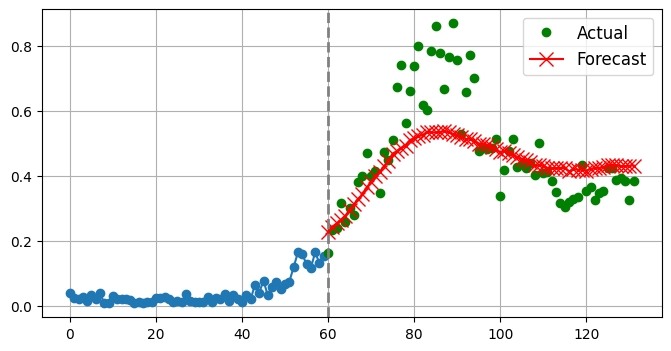

In [79]:
y_pred = model.predict(X_test)
plot_windows(X_test[:, :], y_test[:, :], y_pred[:, :])

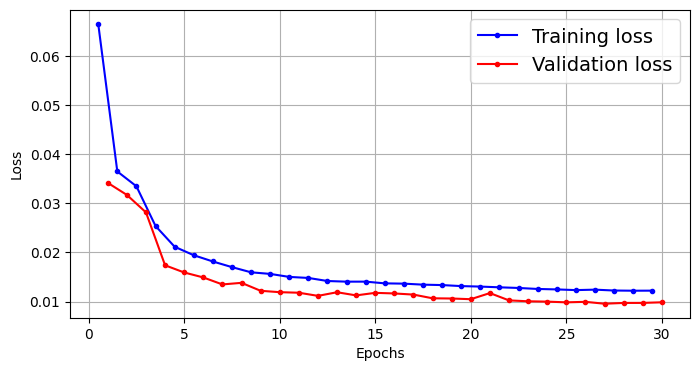

In [80]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

0.9277108433734941 0.0030120481927710836


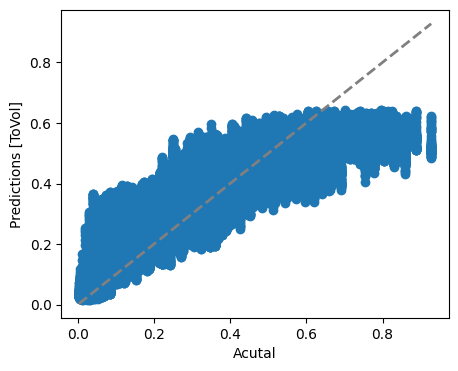

In [81]:
y_max =y_test.flatten()[:,].max()
y_min =y_test.flatten()[:,].min()
print(y_max,y_min)
plot_pred(y_min,y_max)

## b4) many to many with GRU

In [82]:
model =  model_gru()
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, verbose=1)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 60, 10)            390       
                                                                 
 gru_4 (GRU)                 (None, 60, 10)            660       
                                                                 
 gru_5 (GRU)                 (None, 72)                18144     
                                                                 
 dense_11 (Dense)            (None, 72)                5256      
                                                                 
Total params: 24,450
Trainable params: 24,450
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
159/159 [==============================] - 12s 51ms/step - loss: 0.0420 - mae: 0.1602 - val_loss: 0.0309 - val_mae: 0.1406
Epoch 2/30
159/159 [============================

In [83]:
b4, _ = model.evaluate(X_test, y_test)
print('horizon model b4[LSTM]: ', b4)

50/50 [==============================] - 1s 10ms/step - loss: 0.0056 - mae: 0.0546
horizon model b4[LSTM]:  0.005631348118185997


50/50 [==============================] - 1s 10ms/step


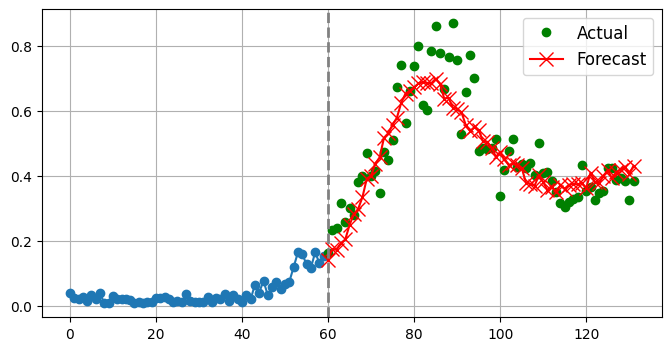

In [84]:
y_pred = model.predict(X_test)
plot_windows(X_test[:, :], y_test[:, :], y_pred[:, :])

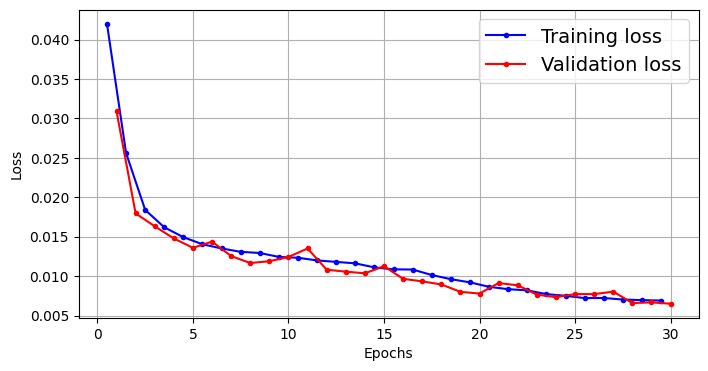

In [85]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

0.9277108433734941 0.0030120481927710836


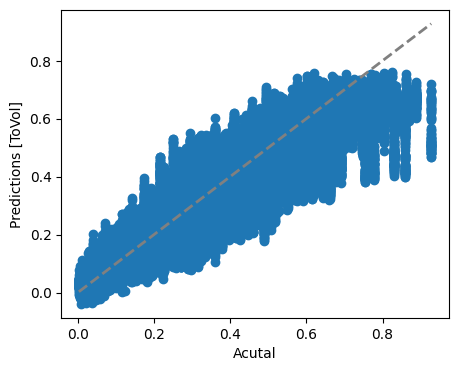

In [86]:
y_max =y_test.flatten()[:,].max()
y_min =y_test.flatten()[:,].min()
print(y_max,y_min)
plot_pred(y_min,y_max)

## (b5) many to many with Conv1D

In [87]:
model = model_conv1d()
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, verbose=1)

Epoch 1/30
159/159 [==============================] - 1s 3ms/step - loss: 0.0362 - mae: 0.1474 - val_loss: 0.0196 - val_mae: 0.1110
Epoch 2/30
159/159 [==============================] - 0s 2ms/step - loss: 0.0201 - mae: 0.1146 - val_loss: 0.0184 - val_mae: 0.1095
Epoch 3/30
159/159 [==============================] - 0s 2ms/step - loss: 0.0187 - mae: 0.1098 - val_loss: 0.0172 - val_mae: 0.1048
Epoch 4/30
159/159 [==============================] - 0s 2ms/step - loss: 0.0178 - mae: 0.1063 - val_loss: 0.0162 - val_mae: 0.1005
Epoch 5/30
159/159 [==============================] - 0s 2ms/step - loss: 0.0168 - mae: 0.1027 - val_loss: 0.0154 - val_mae: 0.0979
Epoch 6/30
159/159 [==============================] - 0s 2ms/step - loss: 0.0158 - mae: 0.0993 - val_loss: 0.0144 - val_mae: 0.0936
Epoch 7/30
159/159 [==============================] - 0s 2ms/step - loss: 0.0150 - mae: 0.0958 - val_loss: 0.0138 - val_mae: 0.0903
Epoch 8/30
159/159 [==============================] - 0s 2ms/step - loss: 0.

50/50 [==============================] - 0s 1ms/step - loss: 0.0070 - mae: 0.0643
horizon model b5[GRU]:  0.006990732625126839
50/50 [==============================] - 0s 1ms/step


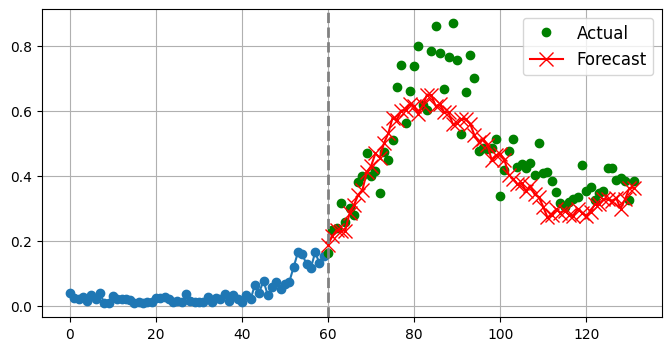

0.9277108433734941 0.0030120481927710836


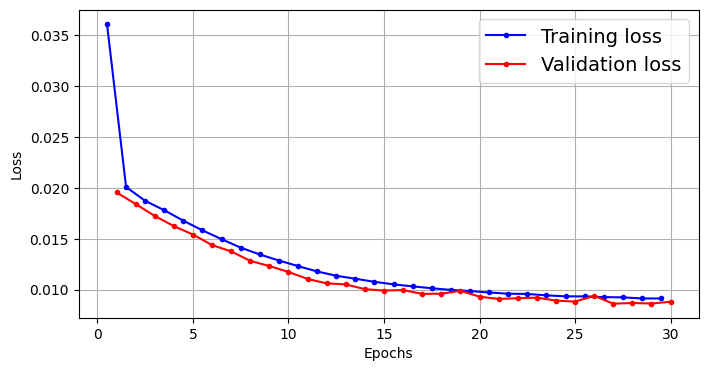

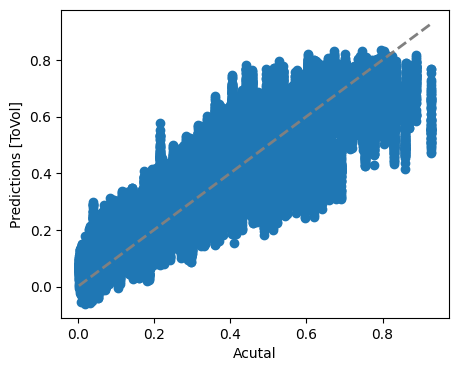

In [88]:
b5, _ = model.evaluate(X_test, y_test)
print('horizon model b5[GRU]: ', b5)

y_pred = model.predict(X_test)
plot_windows(X_test[:, :], y_test[:, :], y_pred[:, :])

plot_learning_curves(history.history["loss"], history.history["val_loss"])

y_max =y_test.flatten()[:,].max()
y_min =y_test.flatten()[:,].min()
print(y_max,y_min)
plot_pred(y_min,y_max)

## (b6) many to many with hybrid  model : Conv1D+LSTM

In [89]:
model =model_cnnlstm()
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, verbose=1)

Epoch 1/30
159/159 [==============================] - 3s 11ms/step - loss: 0.0657 - mae: 0.2003 - val_loss: 0.0507 - val_mae: 0.1697
Epoch 2/30
159/159 [==============================] - 1s 8ms/step - loss: 0.0538 - mae: 0.1749 - val_loss: 0.0472 - val_mae: 0.1609
Epoch 3/30
159/159 [==============================] - 1s 8ms/step - loss: 0.0508 - mae: 0.1670 - val_loss: 0.0453 - val_mae: 0.1566
Epoch 4/30
159/159 [==============================] - 1s 9ms/step - loss: 0.0482 - mae: 0.1609 - val_loss: 0.0419 - val_mae: 0.1497
Epoch 5/30
159/159 [==============================] - 1s 9ms/step - loss: 0.0426 - mae: 0.1500 - val_loss: 0.0357 - val_mae: 0.1361
Epoch 6/30
159/159 [==============================] - 1s 9ms/step - loss: 0.0364 - mae: 0.1380 - val_loss: 0.0328 - val_mae: 0.1312
Epoch 7/30
159/159 [==============================] - 1s 9ms/step - loss: 0.0313 - mae: 0.1277 - val_loss: 0.0251 - val_mae: 0.1164
Epoch 8/30
159/159 [==============================] - 1s 8ms/step - loss: 0

50/50 [==============================] - 0s 3ms/step - loss: 0.0069 - mae: 0.0624
horizon model b6[Conv1D]:  0.006934331264346838
50/50 [==============================] - 1s 3ms/step


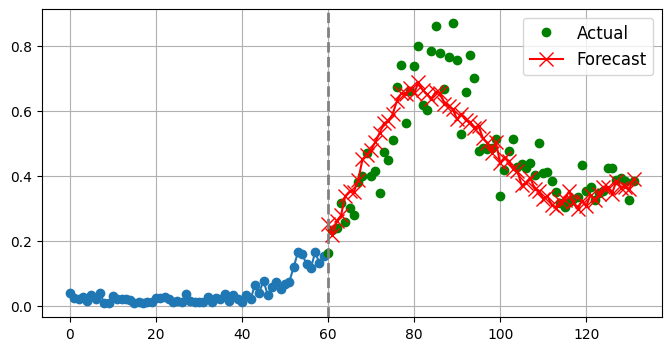

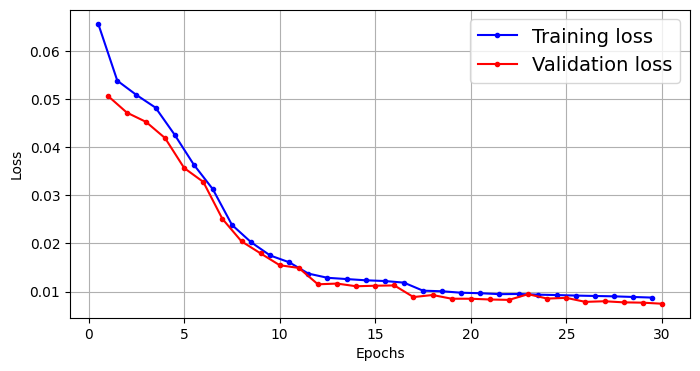

In [90]:
b6, _ = model.evaluate(X_test, y_test)
print('horizon model b6[Conv1D]: ', b6)

y_pred = model.predict(X_test)
plot_windows(X_test[:, :], y_test[:, :], y_pred[:, :])

plot_learning_curves(history.history["loss"], history.history["val_loss"])

0.9277108433734941 0.0030120481927710836


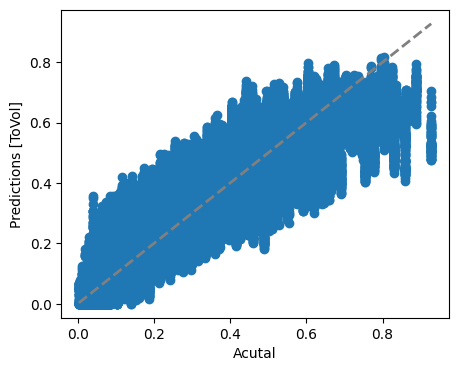

In [91]:
y_max =y_test.flatten()[:,].max()
y_min =y_test.flatten()[:,].min()
print(y_max,y_min)
plot_pred(y_min,y_max)

## Summary of Many to Many Model

In [92]:
df = pd.DataFrame({
    'models': ['DNN', 'SimpleRNN','lSTM','GRU', 'Conv1D','ConvLSTM'],
    'loss':[b1, b2, b3, b4, b5, b6]})
df=df.sort_values(by='loss', ascending=True)

In [93]:
df

,models,loss
3,GRU,0.005631
0,DNN,0.006497
5,ConvLSTM,0.006934
4,Conv1D,0.006991
2,lSTM,0.007380
1,SimpleRNN,0.012190


<Axes: xlabel='models'>

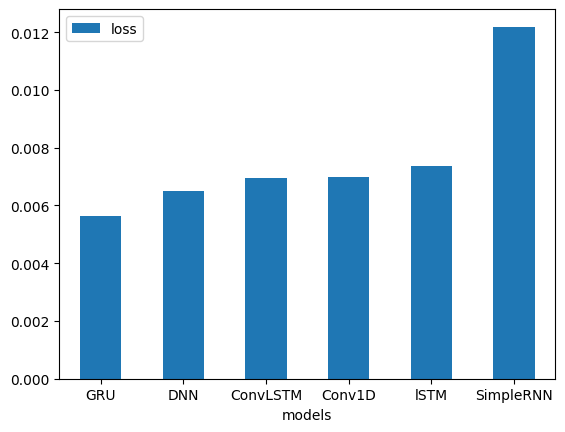

In [94]:
df.plot.bar(x='models', y='loss', rot=0)